Loading "/content/digit.png"...
Preprocessing...


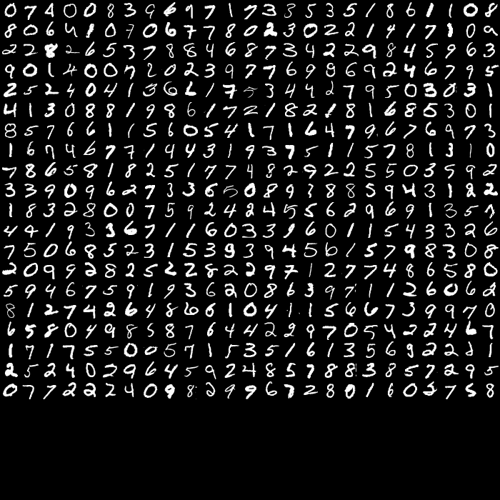

Training KNearest...
Error: 3.40 %
Confusion matrix:
 [[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  1  0  0  0  0  1  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 38  0  2  0  0  0]
 [ 0  0  0  2  0 48  0  0  1  0]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  1  0  0 46  0]
 [ 1  1  0  1  1  0  0  0  2 42]] 



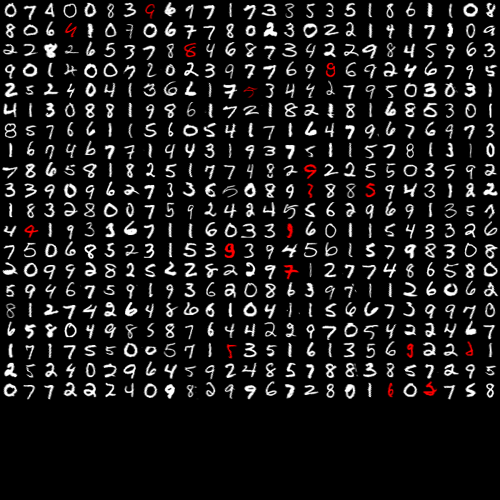

Training SVM...
Error: 1.80 %
Confusion matrix:
 [[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  2  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  1  0 50  0  0  0  0]
 [ 0  0  0  0  1  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 47  0]
 [ 0  1  0  1  0  0  0  0  1 45]] 



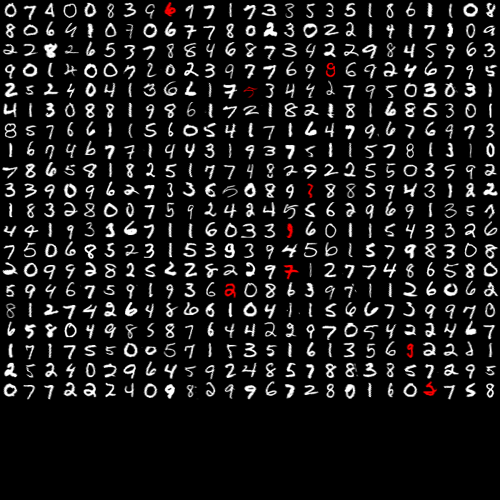

Saving SVM model to digits_svm.dat...


In [ ]:
import numpy as np
import cv2 as cv
from numpy.linalg import norm
from google.colab.patches import cv2_imshow

# Constants
SZ = 20  # Size of each digit (20x20)
CLASS_N = 10
DIGITS_FN = r"/content/digit.png"

# ========== Utilities ==========
def clock():
    return cv.getTickCount() / cv.getTickFrequency()

def mosaic(w, imgs):
    """Create a mosaic of color or grayscale images in a grid"""
    imgs = list(imgs)
    img0 = imgs[0]
    h, w_img = img0.shape[:2]
    is_color = len(img0.shape) == 3 and img0.shape[2] == 3
    dtype = img0.dtype

    # Create empty canvas
    if is_color:
        vis = np.zeros((h * w, w_img * w, 3), dtype)
    else:
        vis = np.zeros((h * w, w_img * w), dtype)

    for i, img in enumerate(imgs):
        x = i % w
        y = i // w
        if y >= w:
            break
        if is_color:
            vis[y*h:(y+1)*h, x*w_img:(x+1)*w_img, :] = img
        else:
            vis[y*h:(y+1)*h, x*w_img:(x+1)*w_img] = img

    return vis


# ========== Data Processing ==========
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    fn = cv.samples.findFile(fn)
    print('Loading "%s"...' % fn)
    digits_img = cv.imread(fn, cv.IMREAD_GRAYSCALE)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits) // CLASS_N)
    return digits, labels

def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SZ * skew], [0, 1, 0]])
    return cv.warpAffine(img, M, (SZ, SZ), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)

def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv.Sobel(img, cv.CV_32F, 1, 0)
        gy = cv.Sobel(img, cv.CV_32F, 0, 1)
        mag, ang = cv.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n * ang / (2 * np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)

# ========== Models ==========
class KNearest:
    def __init__(self, k=3):
        self.k = k
        self.model = cv.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        _, results, _, _ = self.model.findNearest(samples, self.k)
        return results.ravel()

    def save(self, fn):
        self.model.save(fn)

    def load(self, fn):
        self.model = cv.ml.KNearest_load(fn)

class SVM:
    def __init__(self, C=1, gamma=0.5):
        self.model = cv.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv.ml.SVM_RBF)
        self.model.setType(cv.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        return self.model.predict(samples)[1].ravel()

    def save(self, fn):
        self.model.save(fn)

    def load(self, fn):
        self.model = cv.ml.SVM_load(fn)

# ========== Evaluation ==========
def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('Error: %.2f %%' % (err * 100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[int(i), int(j)] += 1
    print('Confusion matrix:\n', confusion, '\n')

    vis = []
    for img, correct in zip(digits, resp == labels):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        if not correct:
            img[..., :2] = 0  # highlight errors in red
        vis.append(img)
    return mosaic(25, vis)

# ========== Main ==========
if __name__ == '__main__':
    digits, labels = load_digits(DIGITS_FN)

    print('Preprocessing...')
    rand = np.random.RandomState(321)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]

    digits_deskewed = list(map(deskew, digits))
    samples = preprocess_hog(digits_deskewed)

    train_n = int(0.9 * len(samples))
    digits_train, digits_test = np.split(digits_deskewed, [train_n])
    samples_train, samples_test = np.split(samples, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])

    cv2_imshow(mosaic(25, digits[train_n:]))

    print('Training KNearest...')
    knn = KNearest(k=4)
    knn.train(samples_train, labels_train)
    vis_knn = evaluate_model(knn, digits_test, samples_test, labels_test)
    cv2_imshow(vis_knn)

    print('Training SVM...')
    svm = SVM(C=2.67, gamma=5.383)
    svm.train(samples_train, labels_train)
    vis_svm = evaluate_model(svm, digits_test, samples_test, labels_test)
    cv2_imshow(vis_svm)

    print('Saving SVM model to digits_svm.dat...')
    svm.save('digits_svm.dat')